In [28]:
import pandas as pd
import numpy as np
from pandas_datareader import DataReader as pdr
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

## Data

#### Returns from second_backtest

In [29]:
rets = pd.read_csv("files/rets_another_backtest.csv", parse_dates=["date"], index_col="date")
rets.index = rets.index.to_period("M")

#### Fama-French factors

In [30]:
ff = pdr("F-F_Research_Data_5_Factors_2x3", "famafrench", start=2005)[0]/100

#### Market and 130/30 returns

In [31]:
rets["mkt"] = ff["Mkt-RF"] + ff["RF"]
rets["ls"] = 1.3*rets["best"] - 0.3*rets["worst"]
rets["rf"] = ff["RF"]

## Raw Returns

#### Accumulations

<AxesSubplot: xlabel='date'>

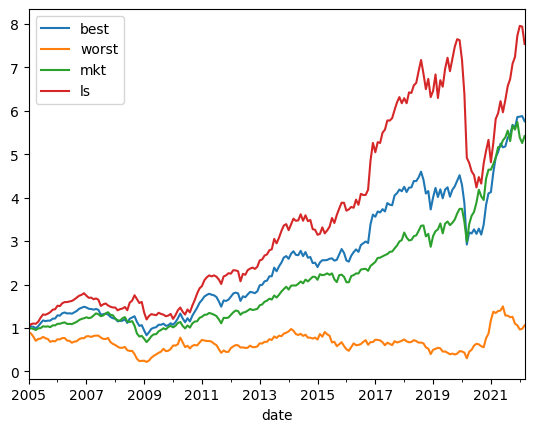

In [32]:
(1+rets[["best", "worst", "mkt", "ls"]]).cumprod().plot()

#### Means and risks

In [33]:
print(12*rets[["best", "worst", "mkt", "ls"]].mean())
print(np.sqrt(12)*rets[["best", "worst", "mkt", "ls"]].std())

best     0.116603
worst    0.063585
mkt      0.109803
ls       0.132509
dtype: float64
best     0.169795
worst    0.353870
mkt      0.150797
ls       0.171079
dtype: float64


#### Excess returns and Sharpe ratios

In [34]:
xrets = rets[["best", "worst", "mkt", "ls"]].subtract(rets.rf, axis=0)
sharpes = np.sqrt(12)*xrets.mean()/xrets.std()
sharpes

best     0.618020
worst    0.147445
mkt      0.651299
ls       0.706983
dtype: float64

#### 130/30 drawdowns

Text(0, 0.5, ' % Drawdown')

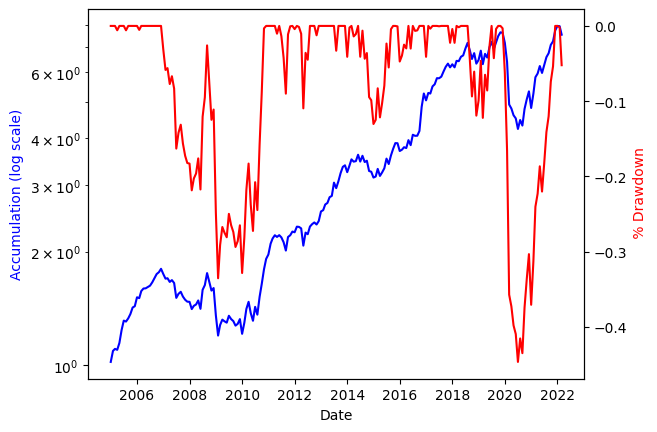

In [35]:
ls = (1+rets.ls).cumprod()
lsmax = ls.expanding().max()
drawdown = ls/lsmax - 1

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.set_yscale("log")
ax1.plot(rets.index.to_timestamp(), ls, 'b-')
ax2.plot(rets.index.to_timestamp(), drawdown, 'r-')

ax1.set_xlabel('Date')
ax1.set_ylabel('Accumulation (log scale)', color='b')
ax2.set_ylabel(' % Drawdown', color='r')

## Market benchmark

#### Regressions on excess market return

In [36]:
tables = []
coefs = []
actives = []

for string in ["best~mkt", "worst~mkt", "ls~mkt"]:
    result = smf.ols(string, data=xrets).fit()
    tables.append(result.summary().tables[1])
    coefs.append(result.params)
    actives.append(result.params["Intercept"] + result.resid)


#### Regression tables

In [37]:
for table in tables:
    print(table)

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0014      0.002      0.671      0.503      -0.003       0.006
mkt            0.8964      0.048     18.804      0.000       0.802       0.990
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0097      0.005     -1.962      0.051      -0.019    4.75e-05
mkt            1.7140      0.112     15.345      0.000       1.494       1.934
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0048      0.003      1.656      0.099      -0.001       0.010
mkt            0.6511      0.065     10.045      0.000       0.523       0.779


#### Active returns and risks

In [38]:
actives = [pd.Series(x, index=xrets.index) for x in actives]
actives = pd.concat(actives, axis=1)
actives.columns = ["best", "worst", "ls"]
np.sqrt(12) * actives.std()


best     0.103205
worst    0.241843
ls       0.140333
dtype: float64

#### Information ratios

In [39]:
info_ratios = np.sqrt(12)*actives.mean()/actives.std()
info_ratios

best     0.164798
worst   -0.481885
ls       0.406694
dtype: float64

#### 130/30 breakdown into market and active returns

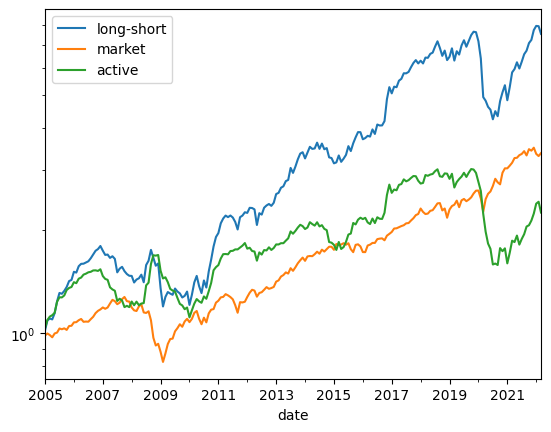

In [40]:
logy = True

beta = coefs[-1]["mkt"]

(1+rets.ls).cumprod().plot(label="long-short", logy=logy)
(1+ rets.rf + beta*xrets.mkt).cumprod().plot(label="market", logy=logy)
(1+actives.ls).cumprod().plot(label="active", logy=logy)
plt.legend()

## Fama-French Benchmark

#### Fama-French factors

In [41]:
xrets[["smb", "hml", "rmw", "cma"]] = ff[["SMB", "HML", "RMW", "CMA"]]

#### Fama-French regressions

In [42]:
tables = []
coefs = []
actives = []

strings = [x+"~mkt+smb+hml+rmw+cma" for x in ["best", "worst", "ls"]]
for string in strings:
    result = smf.ols(string, data=xrets).fit()
    tables.append(result.summary().tables[1])
    coefs.append(result.params)
    actives.append(result.params["Intercept"] + result.resid)

#### Regression tables

In [43]:
for table in tables:
    print(table)

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0035      0.001      2.533      0.012       0.001       0.006
mkt            0.6715      0.034     19.868      0.000       0.605       0.738
smb            0.6102      0.060     10.125      0.000       0.491       0.729
hml            0.5819      0.054     10.818      0.000       0.476       0.688
rmw            0.1370      0.079      1.729      0.085      -0.019       0.293
cma           -0.2598      0.096     -2.697      0.008      -0.450      -0.070
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0050      0.004     -1.200      0.231      -0.013       0.003
mkt            1.3733      0.104     13.191      0.000       1.168       1.579
smb            1.3071      0.186      7.041      0.0

#### Active returns and risks

In [44]:
actives = [pd.Series(x, index=xrets.index) for x in actives]
actives = pd.concat(actives, axis=1)
actives.columns = ["best", "worst", "ls"]
np.sqrt(12) * actives.std()

best     0.063839
worst    0.196657
ls       0.110711
dtype: float64

#### Information ratios

In [45]:

info_ratios = np.sqrt(12)*actives.mean()/actives.std()
info_ratios

best     0.649938
worst   -0.308052
ls       0.651365
dtype: float64

#### 130/30 attribution analysis

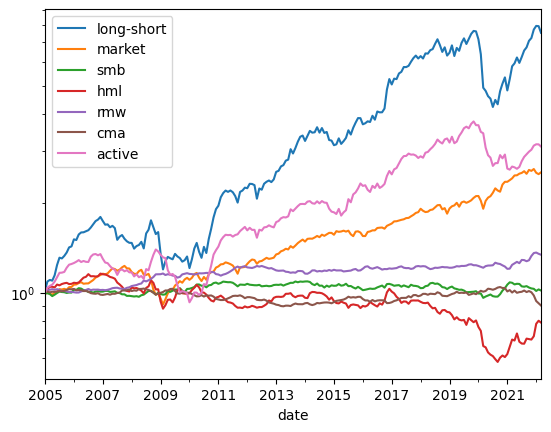

In [46]:
logy = True

betas = coefs[-1]

(1+rets.ls).cumprod().plot(label="long-short", logy=logy)
(1 + rets.rf + betas["mkt"]*xrets.mkt).cumprod().plot(label="market", logy=logy)
(1 + betas["smb"]*xrets.smb).cumprod().plot(label="smb", logy=logy)
(1 + betas["hml"]*xrets.hml).cumprod().plot(label="hml", logy=logy)
(1 + betas["rmw"]*xrets.rmw).cumprod().plot(label="rmw", logy=logy)
(1 + betas["cma"]*xrets.cma).cumprod().plot(label="cma", logy=logy)
(1+actives.ls).cumprod().plot(label="active", logy=logy)
plt.legend()

## Investing in SPY

In [47]:
!pip install yfinance


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [48]:
import yfinance as yf

spy = yf.download('spy', start='2004-01-01', progress=False)['Adj Close']
spy = spy.resample('M').last()
spy = spy.pct_change().dropna()
spy.index = spy.index.to_period('M')

C:\Users\keb7\AppData\Local\Temp\ipykernel_46700\3975516332.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  spy.index = spy.index.to_period('M')


In [49]:
rets["spy"] = spy
rets["ls_spy"] = rets.spy + 0.3*rets.best - 0.3*rets.worst